Import

In [11]:
import pandas as pd
import json
import tensorflow as tf
import matplotlib.pyplot as plt

Tensorflow Data Pipeline

In [12]:
# ========== Dataset loading ==============

directory = "./data"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=120,
    validation_split=0.30,
    subset="training",
    verbose=True)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=120,
    validation_split=0.30,
    subset="validation",
    verbose=True)

# ========== Data Preprocessing ==============

def image_rescaling(img, y):
    img = img * (1./255)
    return img, y

train_dataset = train_dataset.map(image_rescaling)
validation_dataset = validation_dataset.map(image_rescaling)

# =========== Prefetchig to efficiently load the dataset in memory =========
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE) 


Found 3017 files belonging to 16 classes.
Using 2112 files for training.
Found 3017 files belonging to 16 classes.
Using 905 files for validation.


img: AxesImage(shape=(128, 128, 3))
target: tf.Tensor(7, shape=(), dtype=int32)


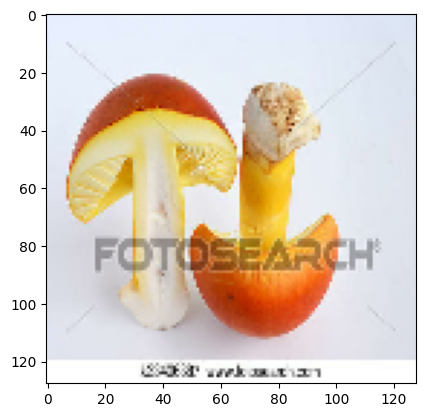

In [13]:
for img, y in train_dataset:
    print("img:", plt.imshow(img[2].numpy()))
    print("target:",y[0])
    break
plt.show()

#### Modelling

In [28]:
def get_model():
    # Input Layer
    image_input = tf.keras.Input(shape=(128, 128, 3), name='image_input')
    # Convolution Layers
    x = tf.keras.layers.Conv2D(16, 3, activation="relu")(image_input)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    ## Fully Connected Layer
    features_output = tf.keras.layers.GlobalMaxPooling2D(data_format="channels_last", keepdims=False)(x)
    x =  tf.keras.layers.Dense(64, activation="relu")(features_output)
    x =  tf.keras.layers.Dense(64, activation="relu")(x)
    output =  tf.keras.layers.Dense(16, name="output")(x)

    # Model Definition
    model = tf.keras.Model(image_input, output, name="mashroom-model")
    model.summary()
    return model

In [29]:
model = get_model()
# ====== Model Compile ======
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.AUC()],
              )

Model: "mashroom-model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,944 (128.69 KB)

 Trainable params: 32,944 (128.69 KB)

 Non-trainable params: 0 (0.00 B)

# Traning will be carried out in Google-Collab ...